In [1]:
import numpy as np
np.set_printoptions(precision=3,suppress=True)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import scipy.stats as st
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pymc3 as pm

In [2]:
import platform
import theano as tt
print('python:',platform.python_version())
print('numpy:',np.__version__)
print('pymc3:',pm.__version__)
print('theano:',tt.__version__)

python: 3.7.4
numpy: 1.16.5
pymc3: 3.7
theano: 1.0.4


In [3]:
XN = 3
Xc = np.linspace(0,10,XN)[:,np.newaxis] # column vector for pymc3
X = np.linspace(1,XN+1,XN) # X labels for plots

In [4]:
# Squared exponential K func, hyperparameter l>0 controls spatial correlation over X
# (l: larger value gives more spatial correlation, smaller gives more independence)

def pmSqExpK(Xc,l,nu=None,wNoise=None):
    Kfunc = pm.gp.cov.ExpQuad(1, l)
    if nu is not None: Kfunc *= nu
    if wNoise is not None: Kfunc += pm.gp.cov.WhiteNoise(np.sqrt(wNoise)) # sigma^2*I
    K = Kfunc(Xc).eval() # requires column vector Xc
    return K,Kfunc

True mixture of Theta to Mu: [6, 4]


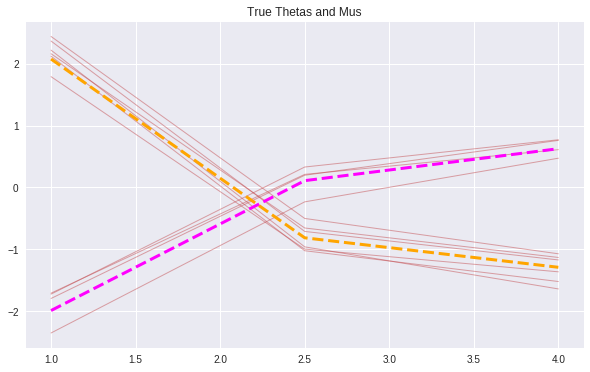

In [5]:
# true mixture weights
w_true = [0.6,0.4]
J = len(w_true)

# true Mus, each sampled from a zero-mean GP with SqExp cov with the same nu, lengthscale
nu_Mu = 1
l_Mu = 2
rs_Mu = [85,156]
Mu_true = np.zeros((J,XN))
K_Mu_true = np.zeros((J,XN,XN))
K_Mu_true_func = []
for j in range(J):
    K,K_func = pmSqExpK(Xc,l_Mu,nu_Mu,1e-6)
    K_Mu_true[j] = K
    K_Mu_true_func.append(K_func)
    Mu_true[j] = st.multivariate_normal.rvs(None,K_Mu_true[j],size=1,random_state=rs_Mu[j])
#     Mu_true[j] = st.multivariate_normal.rvs(None,K_Mu_true[j],size=1)

# true covs, SqExp with the same nu, lengthscale
nu_Q = 0.1
l_Q = 10
Q_true,Q_true_func = pmSqExpK(Xc,l_Q,nu_Q,1e-6)   

# true Thetas
I = 10
mix_true = [int(wt*I) for wt in w_true]
print('True mixture of Theta to Mu:',mix_true) 

Theta_i_true = []
j_i_true = [] # map from Thetas to Mus
for j in range(J):
    Theta_i_true.append(st.multivariate_normal.rvs(Mu_true[j],Q_true,size=mix_true[j]))
    j_i_true.append(j*np.ones(mix_true[j]))
Theta_i_true = np.vstack(Theta_i_true)
j_i_true = np.hstack(j_i_true).astype(int)

# shuffle Thetas
shuffInd = np.random.choice(I,size=I,replace=False)
Theta_i_true = Theta_i_true[shuffInd]
j_i_true = j_i_true[shuffInd]

# plot Thetas and Mus
mu_cols = ['orange','magenta']
plt.figure(figsize=(10,6))
for i in range(I): plt.plot(X,Theta_i_true[i],'C2',lw=1,alpha=0.5)
for j in range(J): plt.plot(X,Mu_true[j],mu_cols[j],ls='--',lw=3)
plt.title('True Thetas and Mus')
plt.show()

In [6]:
def buildPM3model(thActiveInds,thMeas,mNoise):

    with pm.Model() as pmModel:

        # symmetric Dirichlet prior on mixture weights
        w = pm.Dirichlet('w', np.ones(J))

        # Mus likelihood
        Mu_j = []
        for j in range(J):
            mu_gp = pm.gp.Latent(cov_func=K_Mu_true_func[j])
            mu = mu_gp.prior('Mu_%d'%j, X=Xc)
            Mu_j.append(mu)

        # mixture distributions
        mix_dists = []
        for j in range(J):
            mix_dists.append(pm.MvNormal.dist(mu=Mu_j[j], cov=Q_true))

        # Thetas (from mixture)
        Theta_i = pm.Mixture('Theta_i', w, mix_dists, shape=(I+extraI,XN)) # include extra Thetas

        # add likelihoods of measurements for Thetas 1 to I
        for i in range(I):
            for x in thActiveInds[i]:
                y = pm.Normal('th_%d_y_%d'%(i,x), mu=Theta_i[i,x],
                              sigma=mNoise, observed=np.mean(thMeas[i][x]))

        # perform MCMC sampling
        trace = pm.sample(draws=1000,tune=1000,max_treedepth=15)

    return trace

time 0, sample prior (no measurements)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Theta_i, Mu_1_rotated_, Mu_0_rotated_, w]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:38<00:00, 18.29draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Theta 11 trace shape: (2000, 3)
Over the last 1000 samples from final trace:


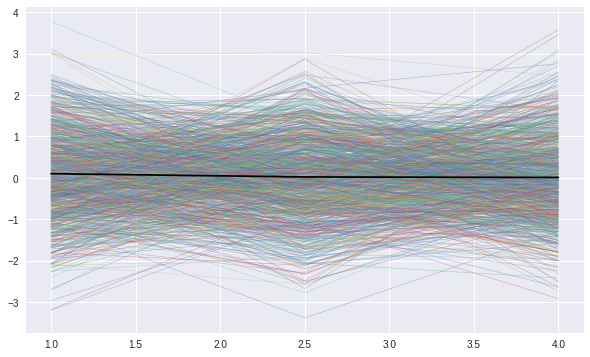

Theta 12 trace shape: (2000, 3)
Over the last 1000 samples from final trace:


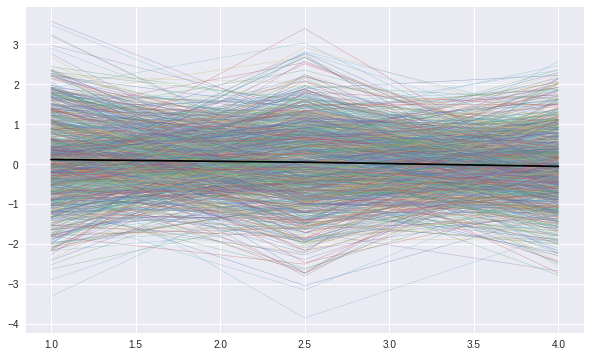

Theta 13 trace shape: (2000, 3)
Over the last 1000 samples from final trace:


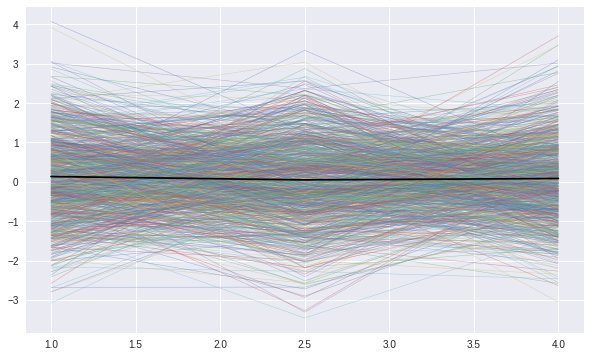

time 1, Theta 3, X 3, meas -1.08
time 2, Theta 3, X 2, meas -0.50
time 3, Theta 3, X 1, meas 2.42
time 4, Theta 4, X 3, meas 0.48
time 5, Theta 1, X 3, meas -1.39
time 6, Theta 10, X 1, meas 2.38
time 7, Theta 2, X 2, meas -0.98
time 8, Theta 9, X 2, meas 0.21
time 9, Theta 2, X 1, meas 2.22
time 10, Theta 10, X 3, meas -1.14
time 11, Theta 8, X 3, meas -1.48
time 12, Theta 5, X 2, meas 0.37
time 13, Theta 10, X 2, meas -0.74
time 14, Theta 2, X 3, meas -1.62
time 15, Theta 4, X 2, meas -0.22
time 16, Theta 5, X 3, meas 0.77
time 17, Theta 8, X 1, meas 2.11
time 18, Theta 8, X 2, meas -1.07
time 19, Theta 6, X 2, meas -0.66
time 20, Theta 1, X 1, meas 1.77
time 21, Theta 7, X 2, meas 0.22
time 22, Theta 9, X 3, meas 0.69
time 23, Theta 6, X 3, meas -1.16
time 24, Theta 9, X 1, meas -1.77
time 25, Theta 4, X 1, meas -2.30
time 26, Theta 5, X 1, meas -1.72
time 27, Theta 1, X 2, meas -1.06
time 28, Theta 7, X 1, meas -1.75
time 29, Theta 7, X 3, meas 0.74
time 30, Theta 6, X 1, meas 2.27

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Theta_i, Mu_1_rotated_, Mu_0_rotated_, w]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:38<00:00, 104.48draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
# Theta measurement sequence
s = []
for i in range(I): s.extend([i,]*XN)
np.random.shuffle(s)
T = len(s)

# sigma for measurement noise
mNoise = np.sqrt(1e-3)

# extra Thetas
extraI = 3

# Theta measurements
thActiveInds = [[] for _ in range(I)]
thMeas = [[[] for _ in range(XN)] for _ in range(I)]

# sample prior model (no measurements)
print('time 0, sample prior (no measurements)')
trace = buildPM3model(thActiveInds,thMeas,mNoise)

# plot extra Thetas from prior trace
plotN = 1000
for i in range(I,I+extraI):
    thi = trace['Theta_i'][:,i]
    print('Theta %d trace shape:'%(i+1),thi.shape)
    print('Over the last %d samples from final trace:'%plotN)
    plt.figure(figsize=(10,6))
    for samp in range(plotN): plt.plot(X,thi[-samp],lw=0.5,alpha=0.5)
    plt.plot(X,np.mean(thi[-plotN:],axis=0),'k')
    plt.show()

# measurements
for t in range(T):

    # Theta i measurement at time t
    i = s[t]
    thiNonActive = [x for x in range(XN) if x not in thActiveInds[i]]
    x = np.random.choice(thiNonActive)
    thActiveInds[i].append(x)
    thMeas[i][x].append(Theta_i_true[i,x] + mNoise*np.random.randn())

    print('time %d, Theta %d, X %d, meas %.2f'%(t+1,i+1,x+1,thMeas[i][x][-1]))

# sample updated model with measurements
trace = buildPM3model(thActiveInds,thMeas,mNoise)

Mu 1 trace shape: (2000, 3)
Over the last 1000 samples from final trace, and true Mu:


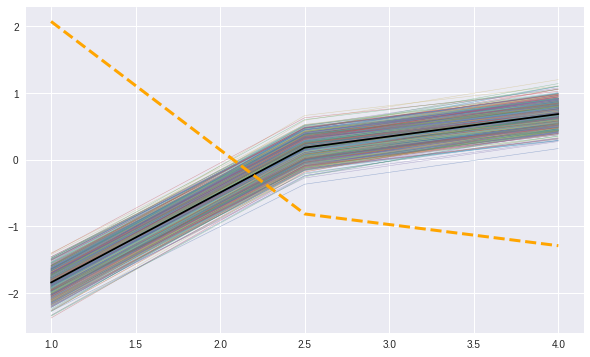

Mu 2 trace shape: (2000, 3)
Over the last 1000 samples from final trace, and true Mu:


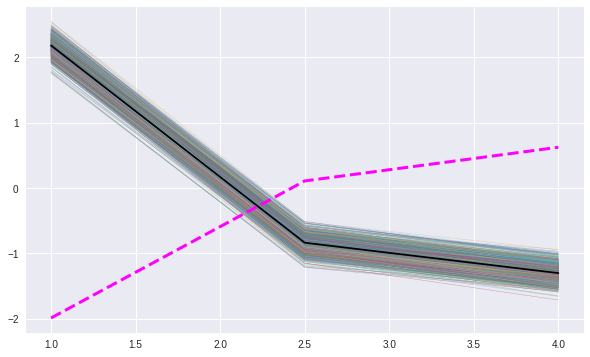

Theta 1 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


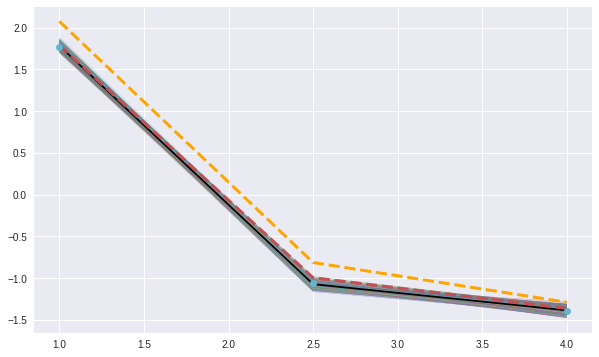

Theta 2 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


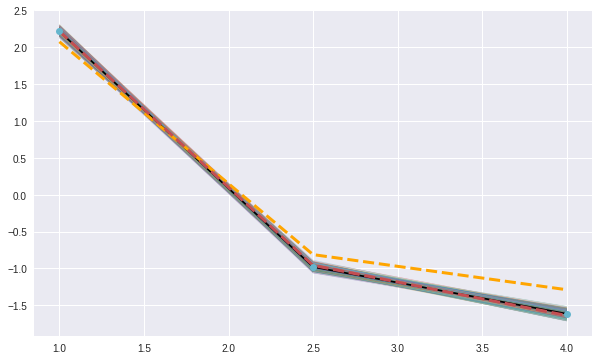

Theta 3 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


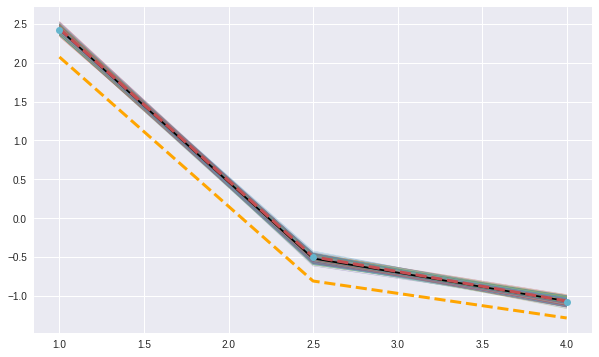

Theta 4 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


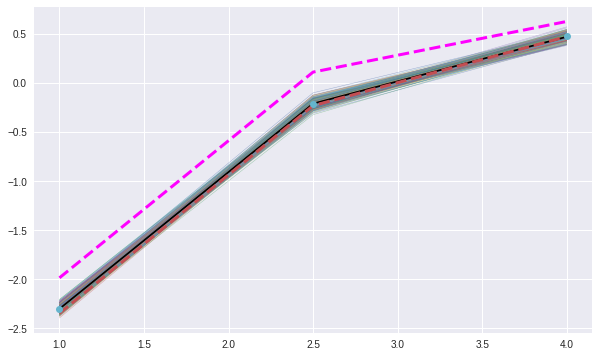

Theta 5 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


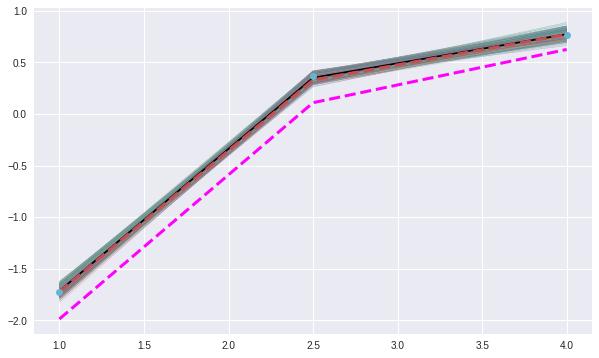

Theta 6 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


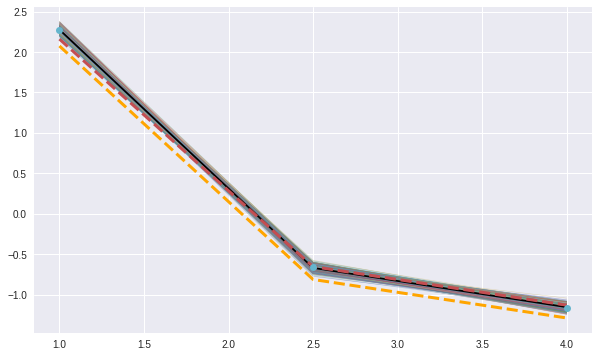

Theta 7 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


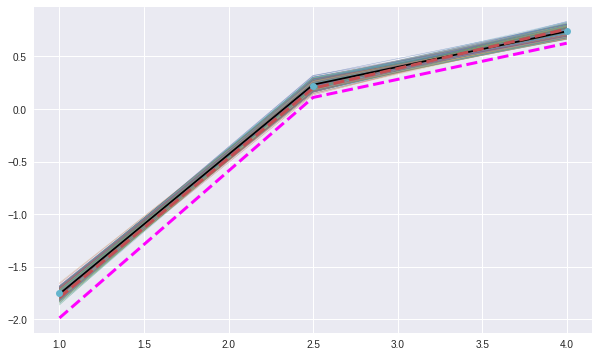

Theta 8 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


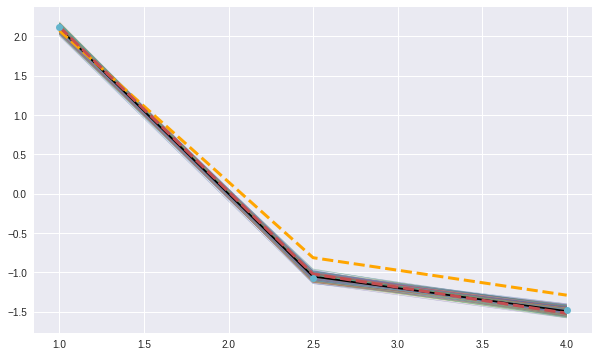

Theta 9 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


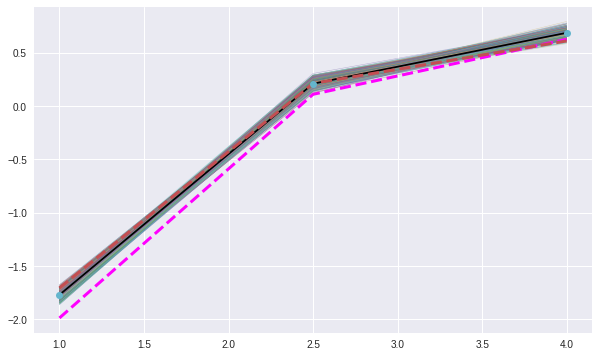

Theta 10 trace shape: (2000, 3)
Over the last 1000 samples from final trace, with measurements, and true Theta and Mu:


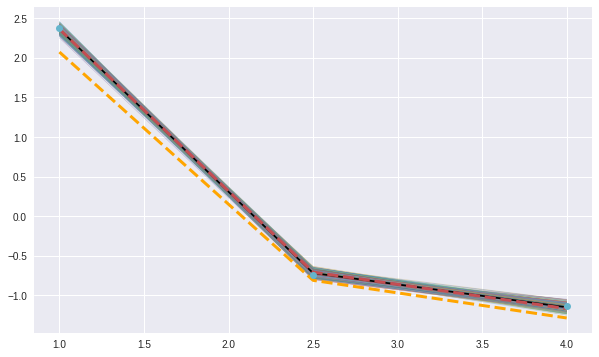

Theta 11 trace shape: (2000, 3)
Over the last 1000 samples from final trace:


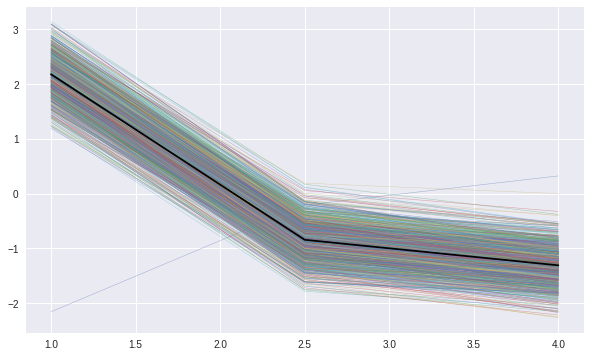

Theta 12 trace shape: (2000, 3)
Over the last 1000 samples from final trace:


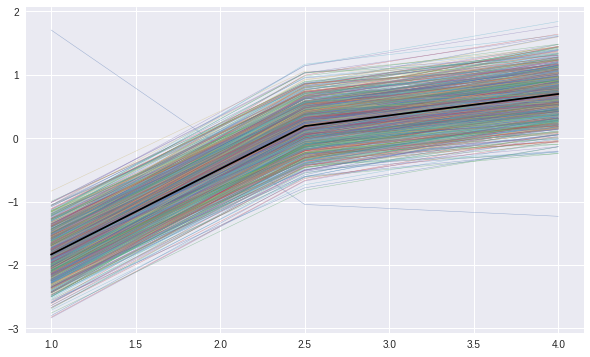

Theta 13 trace shape: (2000, 3)
Over the last 1000 samples from final trace:


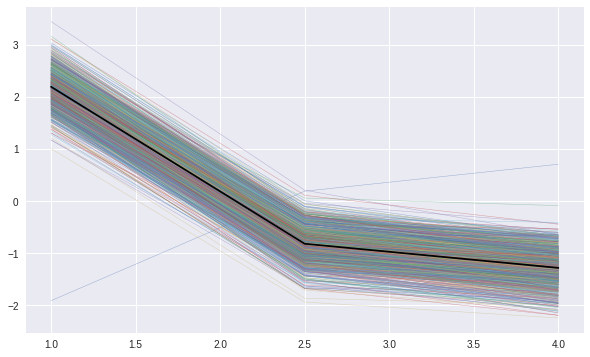

w trace shape: (2000, 2)
Over the last 1000 samples from final trace:
w1 avg: 0.40
w2 avg: 0.60


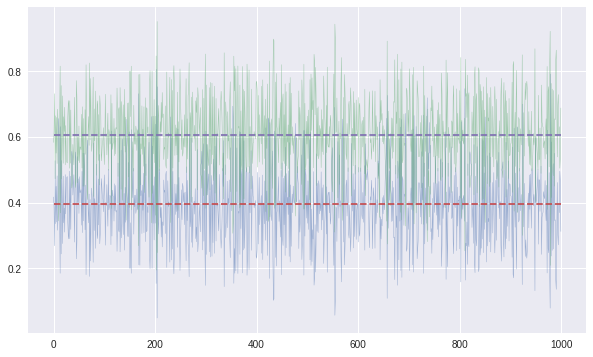

In [8]:
# Plots from final trace

for j in range(J):
    muj = trace['Mu_%d'%j]

    print('Mu %d trace shape:'%(j+1),muj.shape)
    print('Over the last %d samples from final trace, and true Mu:'%plotN)
    plt.figure(figsize=(10,6))
    for s in range(plotN): plt.plot(X,muj[-s],lw=0.5,alpha=0.5)
    plt.plot(X,np.mean(muj[-plotN:],axis=0),'k')
    plt.plot(X,Mu_true[j],mu_cols[j],ls='--',lw=3)
    plt.show()

for i in range(I):
    j = j_i_true[i]
    thi = trace['Theta_i'][:,i]

    print('Theta %d trace shape:'%(i+1),thi.shape)
    print('Over the last %d samples from final trace, with measurements, and true Theta and Mu:'%plotN)

    plt.figure(figsize=(10,6))
    for s in range(plotN): plt.plot(X,thi[-s],lw=0.5,alpha=0.5)
    plt.plot(X,np.mean(thi[-plotN:],axis=0),'k')
    plt.plot(X,Mu_true[j],mu_cols[j],ls='--',lw=3)
    plt.plot(X,Theta_i_true[i],'C2--',lw=3)
    for x in thActiveInds[i]:
        for meas in thMeas[i][x]:
            plt.plot(X[x],meas,'C5o',ms=7)
    plt.show()

for i in range(I,I+extraI):
    thi = trace['Theta_i'][:,i]
    print('Theta %d trace shape:'%(i+1),thi.shape)
    print('Over the last %d samples from final trace:'%plotN)

    plt.figure(figsize=(10,6))
    for s in range(plotN): plt.plot(X,thi[-s],lw=0.5,alpha=0.5)
    plt.plot(X,np.mean(thi[-plotN:],axis=0),'k')
    plt.show()

print('w trace shape:',trace['w'].shape)
print('Over the last %d samples from final trace:'%plotN)
plt.figure(figsize=(10,6))
wjavg = []
for j in range(J):
    wj = trace['w'][-plotN:,j]
    wjavg.append(np.mean(wj))
    print('w%d avg: %.2f'%(j+1,wjavg[-1]))
    plt.plot(wj,lw=0.5,alpha=0.5)
for j in range(J): plt.plot([wjavg[j],]*plotN,'C%d--'%(j+2))
plt.show()